In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings(action="ignore")
%matplotlib inline
sns.set_style("whitegrid")
plt.style.use("fivethirtyeight")

In [2]:
df = pd.read_excel(r"C:\Users\hp\OneDrive\Desktop\Forecast Gold Price\Hotel Review\hotel_reviews.xlsx")
df.head()

,Review,Rating
0,nice hotel expensive parking got good deal sta...,4
1,ok nothing special charge diamond member hilto...,2
2,nice rooms not 4* experience hotel monaco seat...,3
3,"unique, great stay, wonderful time hotel monac...",5
4,"great stay great stay, went seahawk game aweso...",5


In [3]:
# shape of data
df.shape

(20491, 2)

In [4]:
# info of data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20491 entries, 0 to 20490
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Review  20491 non-null  object
 1   Rating  20491 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 320.3+ KB


In [5]:
# Precentage of null values
(df.isna().sum()/len(df))*100

Review    0.0
Rating    0.0
dtype: float64

In [6]:
df.Rating.value_counts()

5    9054
4    6039
3    2184
2    1793
1    1421
Name: Rating, dtype: int64

# EDA

Text(0.5, 1.0, 'Ratings of Hotels')

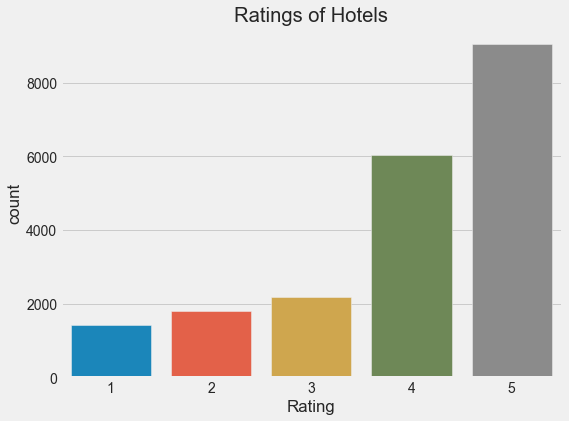

In [7]:
plt.figure(figsize=(8,6))
sns.countplot(df["Rating"])
plt.title("Ratings of Hotels")

<AxesSubplot:>

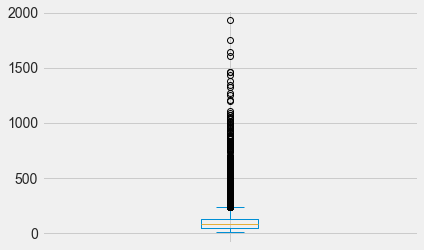

In [8]:
# Calculate review lengths
review_len = pd.Series([len(review.split()) for review in df['Review']])

# The distribution of review text lengths
review_len.plot(kind='box')

<AxesSubplot:ylabel='Count'>

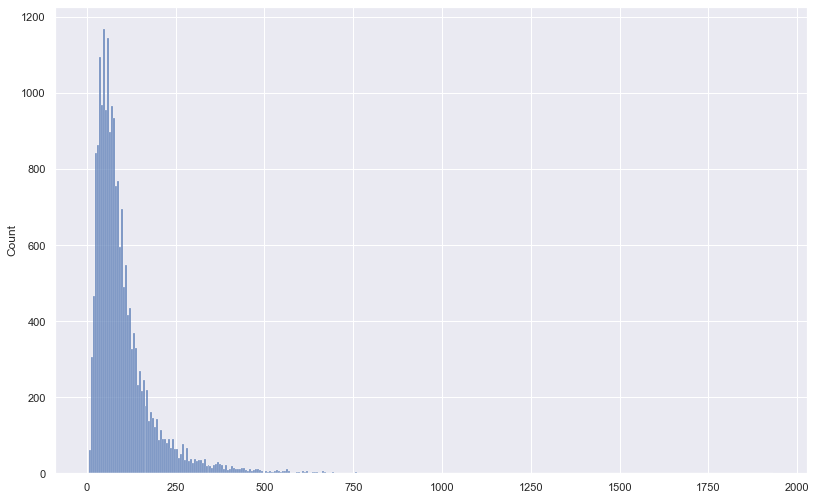

In [9]:
sns.set_theme(
    context='notebook',
    style='darkgrid',
    palette='deep',
    font='sans-serif',
    font_scale=1,
    color_codes=True,
    rc=None,
)
plt.figure(figsize=(12,8))
sns.histplot(review_len)

count    9054.000000
mean       93.963773
std        90.977999
min         7.000000
25%        44.000000
50%        69.000000
75%       111.000000
max      1755.000000
Name: Length, dtype: float64

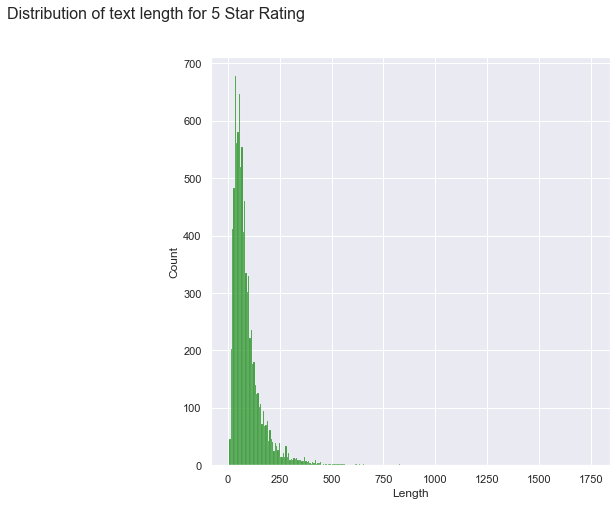

In [10]:
fig = plt.figure(figsize=(14,7))
df["Length"] = df.Review.str.split().apply(len)
ax1 = fig.add_subplot(122)
sns.histplot(df[df['Rating']==5]['Length'], ax=ax1,color='green')
fig.suptitle('Distribution of text length for 5 Star Rating', fontsize=16)
display(df.Length[df.Rating==5].describe())

count    1421.000000
mean      112.365236
std        99.834855
min        12.000000
25%        51.000000
50%        82.000000
75%       137.000000
max       954.000000
Name: Length, dtype: float64

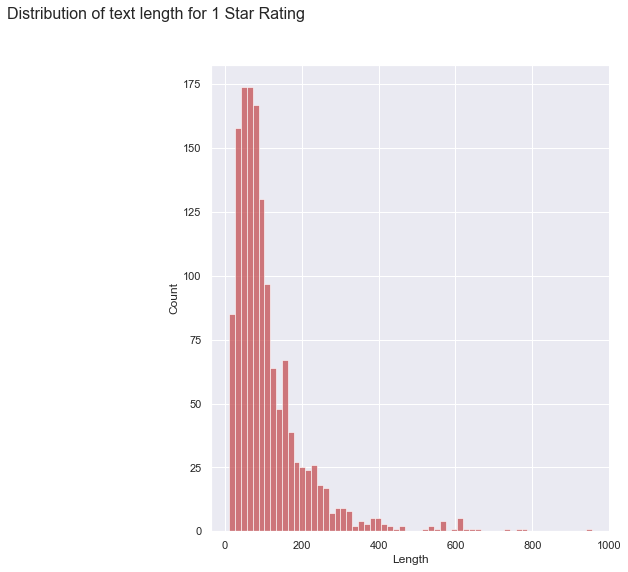

In [11]:
fig2 = plt.figure(figsize=(14,8))
ax2 = fig2.add_subplot(122)
sns.histplot(df[df["Rating"]==1]["Length"],ax=ax2,color='r')
fig2.suptitle("Distribution of text length for 1 Star Rating",fontsize=16)
display(df.Length[df.Rating==1].describe())

## WordCloud

* WordCloud for 1 Star Rating

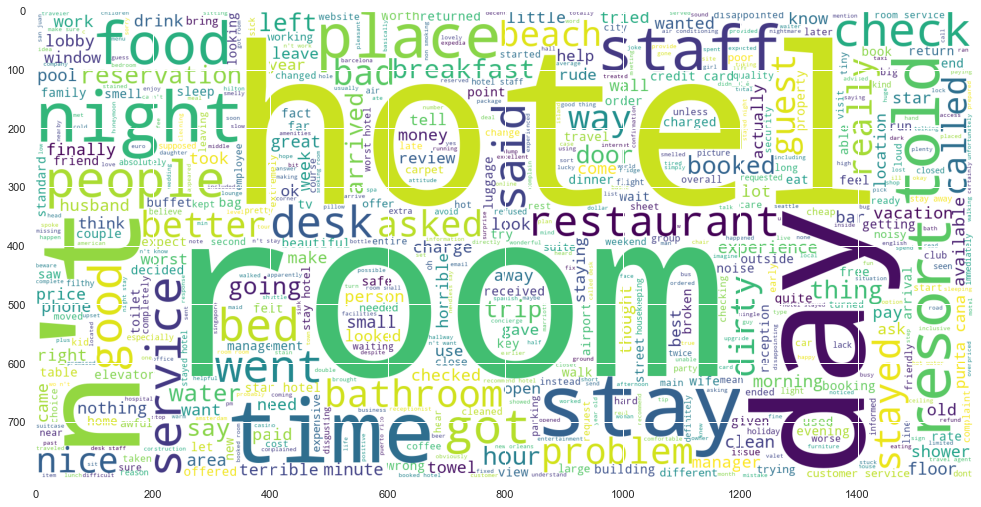

In [12]:
from wordcloud import WordCloud
plt.figure(figsize=(15,15))
wc1 = WordCloud(max_words=2000, min_font_size=10, 
                height=800,width=1600,background_color="white").generate(" ".join(df[df["Rating"]==1].Review))
plt.imshow(wc1)

* WordCloud for 2 Star Rating

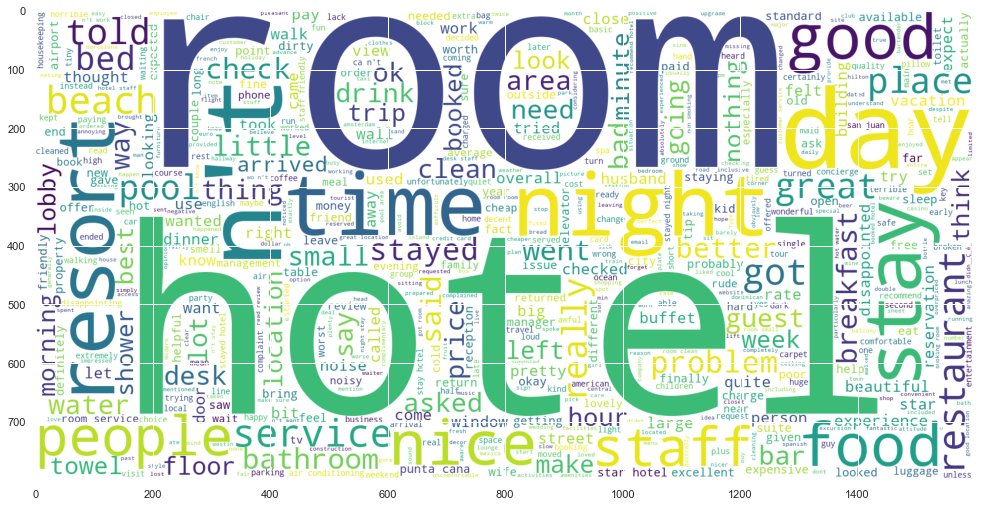

In [13]:
plt.figure(figsize=(15,15))
wc2 = WordCloud(max_words=2000, min_font_size=10, 
                height=800,width=1600,background_color="white").generate(" ".join(df[df["Rating"]==2].Review))
plt.imshow(wc2)

* WordCloud for 3 Star Rating

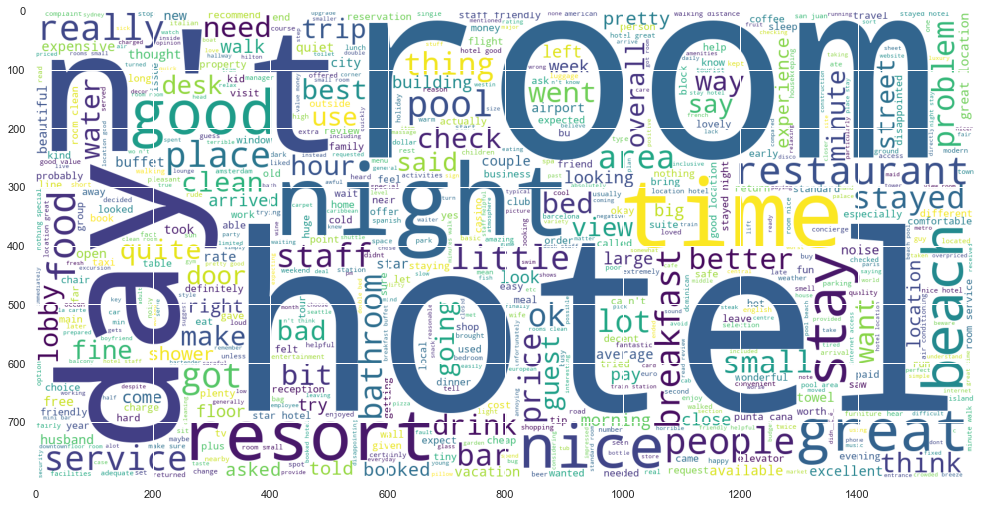

In [14]:
plt.figure(figsize=(15,15))
wc3 = WordCloud(max_words=2000, min_font_size=10, 
                height=800,width=1600,background_color="white").generate(" ".join(df[df["Rating"]==3].Review))
plt.imshow(wc3)

* WordCloud for 4 Star Rating

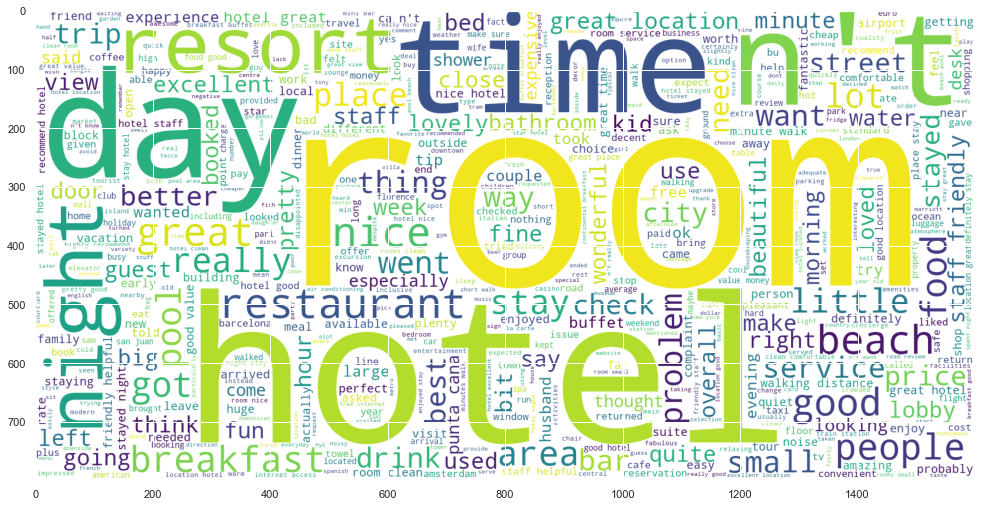

In [15]:
plt.figure(figsize=(15,15))
wc4 = WordCloud(max_words=2000, min_font_size=10, 
                height=800,width=1600,background_color="white").generate(" ".join(df[df["Rating"]==4].Review))
plt.imshow(wc4)

* WordCloud for 5 Star Rating

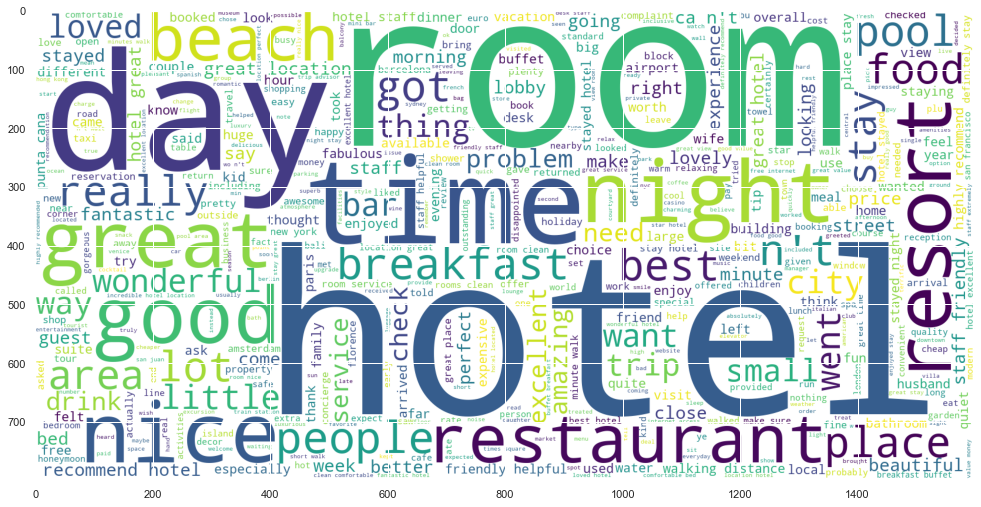

In [16]:
plt.figure(figsize=(15,15))
wc5 = WordCloud(max_words=2000, min_font_size=10, 
                height=800,width=1600,background_color="white").generate(" ".join(df[df["Rating"]==5].Review))
plt.imshow(wc5)

# NLP Approach:
1. Cleaning
2. Lemmatization
3. TF-IDF

In [17]:
# function for cleaning Review
def standardize_text(df, field):
    df[field] = df[field].str.replace(r"http\S+", "")
    df[field] = df[field].str.replace(r"http","")
    df[field] = df[field].str.replace(r"@/S+","")
    df[field] = df[field].str.replace(r"[^A-Za-z0-9(),!?@\'\`\"\_\n]", " ")
    df[field] = df[field].str.replace(r"@"," at ")
    df[field] = df[field].str.lower()
    return df

In [18]:
standardize_text(df,"Review")

,Review,Rating,Length
0,nice hotel expensive parking got good deal sta...,4,87
1,ok nothing special charge diamond member hilto...,2,250
2,nice rooms not 4 experience hotel monaco seat...,3,217
3,"unique, great stay, wonderful time hotel monac...",5,89
4,"great stay great stay, went seahawk game aweso...",5,191
...,...,...,...
20486,"best kept secret 3rd time staying charm, not 5...",5,109
20487,great location price view hotel great quick pl...,4,39
20488,"ok just looks nice modern outside, desk staff ...",2,63
20489,hotel theft ruined vacation hotel opened sept ...,1,781


In [19]:
import re
import string
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk import word_tokenize

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Applying Lemmmatizer to remove tenses from texts.

In [20]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [21]:
import nltk
nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [22]:
lemmatizer = WordNetLemmatizer()
corpus = []
for i in range(0, len(df)):
    review = re.sub('[^a-zA-Z]', ' ', df['Review'][i])
    review = review.split()
    review = [word for word in review if not word in set(stopwords.words('english'))]
    review = [lemmatizer.lemmatize(word) for word in review]
    review = ' '.join(review)
    corpus.append(review)

In [23]:
corpus[:1]

['nice hotel expensive parking got good deal stay hotel anniversary arrived late evening took advice previous review valet parking check quick easy little disappointed non existent view room room clean nice size bed comfortable woke stiff neck high pillow soundproof like heard music room night morning loud bang door opening closing hear people talking hallway maybe noisy neighbor aveda bath product nice goldfish stay nice touch taken advantage staying longer location great walking distance shopping overall nice experience pay parking night']

In [24]:
def sentiment(review):
    if review>=3:
        return 1
    else:
        return 0
df['Sentiment']= df['Rating'].apply(sentiment)

In [25]:
df.head(10)

,Review,Rating,Length,Sentiment
0,nice hotel expensive parking got good deal sta...,4,87,1
1,ok nothing special charge diamond member hilto...,2,250,0
2,nice rooms not 4 experience hotel monaco seat...,3,217,1
3,"unique, great stay, wonderful time hotel monac...",5,89,1
4,"great stay great stay, went seahawk game aweso...",5,191,1
5,love monaco staff husband stayed hotel crazy w...,5,134,1
6,"cozy stay rainy city, husband spent 7 nights m...",5,101,1
7,"excellent staff, housekeeping quality hotel ch...",4,85,1
8,"hotel stayed hotel monaco cruise, rooms genero...",5,59,1
9,excellent stayed hotel monaco past w e delight...,5,35,1


### Applying TF-IDF



In [26]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [27]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(ngram_range=(1, 3), max_features=10000, tokenizer = word_tokenize)
X = tfidf.fit_transform(corpus)
y = df['Sentiment']

In [28]:
import pickle 

In [29]:
pickle.dump(tfidf, open('vectorizer.pkl', 'wb'))

### Splitting data into Training and Testing Set

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.25, random_state=24)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(15368, 10000)
(15368,)
(5123, 10000)
(5123,)


## Sentiment Analysis

In [31]:
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sentiments = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [32]:
sentiments = SentimentIntensityAnalyzer()
df["Positive"] = [sentiments.polarity_scores(i)["pos"] for i in df["Review"]]
df["Negative"] = [sentiments.polarity_scores(i)["neg"] for i in df["Review"]]
df["Neutral"] = [sentiments.polarity_scores(i)["neu"] for i in df["Review"]]
print(df.head())

                                              Review  Rating  Length  \
0  nice hotel expensive parking got good deal sta...       4      87   
1  ok nothing special charge diamond member hilto...       2     250   
2  nice rooms not 4  experience hotel monaco seat...       3     217   
3  unique, great stay, wonderful time hotel monac...       5      89   
4  great stay great stay, went seahawk game aweso...       5     191   

   Sentiment  Positive  Negative  Neutral  
0          1     0.283     0.071    0.646  
1          0     0.196     0.108    0.696  
2          1     0.211     0.107    0.682  
3          1     0.382     0.060    0.558  
4          1     0.221     0.135    0.643  


In [33]:
x = sum(df["Positive"])
y = sum(df["Negative"])
z = sum(df["Neutral"])

def sentiment_score(a, b, c):
    if (a>b) and (a>c):
        print("Positive")
    elif (b>a) and (b>c):
        print("Negative")
    else:
        print("Neutral")
sentiment_score(x, y, z)

Neutral


In [34]:
print("Positive: ", x)
print("Negative: ", y)
print("Neutral: ", z)

Positive:  6394.630999999983
Negative:  1478.2819999999986
Neutral:  12618.152999999964


# Model Training...🚴

### Logistic Regression

In [35]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(X_train, y_train)
lr.score(X_test, y_test)

0.9223111458130002

In [36]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

              precision    recall  f1-score   support

           0       0.59      0.88      0.70       538
           1       0.99      0.93      0.96      4585

    accuracy                           0.92      5123
   macro avg       0.79      0.90      0.83      5123
weighted avg       0.94      0.92      0.93      5123

Accuracy of LR Model: 92.23111458130002%


Text(0.5, 1.0, 'Confusion Matrix for LR Model')

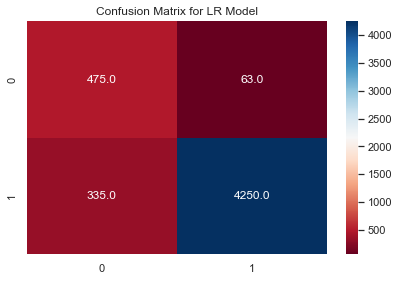

In [37]:
y_pred = lr.predict(X_test)
acc = accuracy_score(y_pred, y_test)
report = classification_report(y_pred, y_test)
print(report)
cm = confusion_matrix(y_pred, y_test)
#np.set_printoptions(precision=0.01)
print("Accuracy of LR Model: {}%".format(acc*100))
sns.heatmap(cm, annot=True, fmt = ".1f",cmap="RdBu")
plt.title("Confusion Matrix for LR Model")

In [38]:
from sklearn.metrics import roc_auc_score, roc_curve

In [39]:
y_pred_proba = lr.predict_proba(X_test)
pos_proba = y_pred_proba[:,1]

Text(0.5, 1.0, 'ROC curve for LR Classifier')

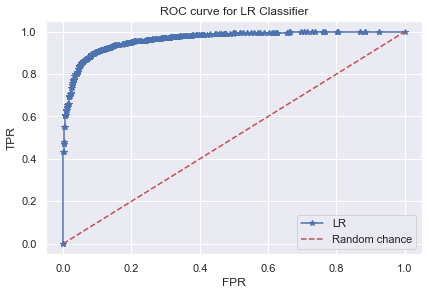

In [40]:
fpr, tpr, thersholds = roc_curve(y_test, pos_proba)
plt.plot(fpr, tpr, "*-")
plt.plot([0,1],[0,1],'r--')
plt.legend(['LR', 'Random chance'])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve for LR Classifier')

### XGBoost

In [41]:
from xgboost import XGBClassifier
xgb = XGBClassifier()
xgb.fit(X_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

In [42]:
xgb.score(X_test, y_test)

0.9184071832910404

              precision    recall  f1-score   support

           0       0.60      0.83      0.70       588
           1       0.98      0.93      0.95      4535

    accuracy                           0.92      5123
   macro avg       0.79      0.88      0.83      5123
weighted avg       0.93      0.92      0.92      5123

Accuracy of XGBOOST Model: 91.84071832910405%


Text(0.5, 1.0, 'Confusion Matrix for XGBOOST Model')

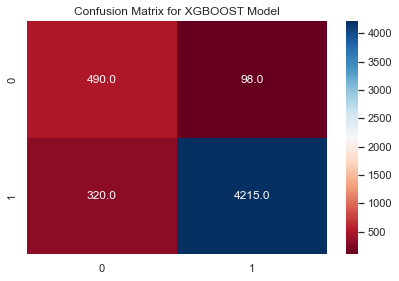

In [43]:
y_pred = xgb.predict(X_test)
acc = accuracy_score(y_pred, y_test)
report = classification_report(y_pred, y_test)
print(report)
cm = confusion_matrix(y_pred, y_test)
#np.set_printoptions(precision=0.01)
print("Accuracy of XGBOOST Model: {}%".format(acc*100))
sns.heatmap(cm, annot=True, fmt = ".1f",cmap="RdBu")
plt.title("Confusion Matrix for XGBOOST Model")

Text(0.5, 1.0, 'ROC curve for XGBOOST Classifier')

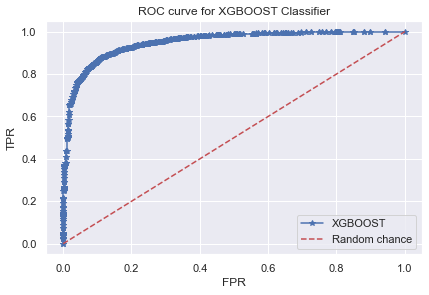

In [44]:
y_pred_proba = xgb.predict_proba(X_test)
pos_proba = y_pred_proba[:,1]
fpr, tpr, thersholds = roc_curve(y_test, pos_proba)
plt.plot(fpr, tpr, "*-")
plt.plot([0,1],[0,1],'r--')
plt.legend(['XGBOOST', 'Random chance'])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve for XGBOOST Classifier')

### LightGBM

In [45]:
pip install pickles

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [46]:
import pickle

In [47]:
from lightgbm import LGBMClassifier
lgb = LGBMClassifier()
lgb.fit(X_train, y_train)
lgb.score(X_test, y_test)

0.9232871364434901

              precision    recall  f1-score   support

           0       0.64      0.84      0.72       617
           1       0.98      0.93      0.96      4506

    accuracy                           0.92      5123
   macro avg       0.81      0.89      0.84      5123
weighted avg       0.94      0.92      0.93      5123

Accuracy of LGBM Model: 92.32871364434901%


Text(0.5, 1.0, 'Confusion Matrix for LGB Model')

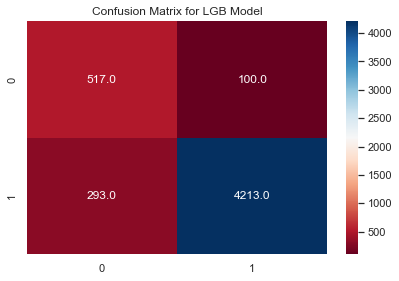

In [48]:
y_pred = lgb.predict(X_test)
acc = accuracy_score(y_pred, y_test)
report = classification_report(y_pred, y_test)
print(report)
cm = confusion_matrix(y_pred, y_test)
#np.set_printoptions(precision=0.01)
print("Accuracy of LGBM Model: {}%".format(acc*100))
sns.heatmap(cm, annot=True, fmt = ".1f",cmap="RdBu")
plt.title("Confusion Matrix for LGB Model")

In [49]:
pickle.dump(lgb, open('model.pkl', 'wb'))

In [50]:
pickled_model = pickle.load(open('model.pkl', 'rb'))

              precision    recall  f1-score   support

           0       0.64      0.84      0.72       617
           1       0.98      0.93      0.96      4506

    accuracy                           0.92      5123
   macro avg       0.81      0.89      0.84      5123
weighted avg       0.94      0.92      0.93      5123

Accuracy of LGBM Model: 92.32871364434901%


Text(0.5, 1.0, 'Confusion Matrix for LGB Model')

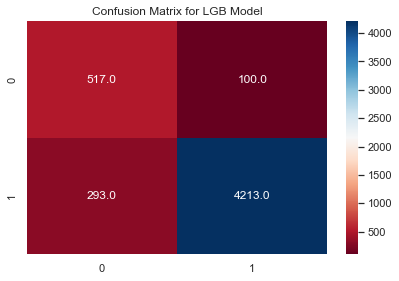

In [51]:
y_pred = pickled_model.predict(X_test)
acc = accuracy_score(y_pred, y_test)
report = classification_report(y_pred, y_test)
print(report)
cm = confusion_matrix(y_pred, y_test)
#np.set_printoptions(precision=0.01)
print("Accuracy of LGBM Model: {}%".format(acc*100))
sns.heatmap(cm, annot=True, fmt = ".1f",cmap="RdBu")
plt.title("Confusion Matrix for LGB Model")

Text(0.5, 1.0, 'ROC curve for LGB Classifier')

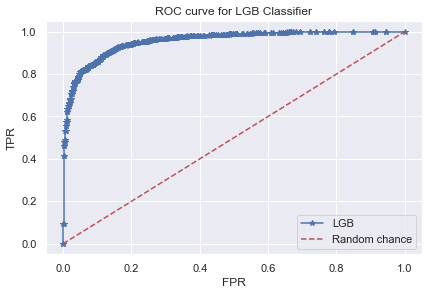

In [52]:
y_pred_proba = lgb.predict_proba(X_test)
pos_proba = y_pred_proba[:,1]
fpr, tpr, thersholds = roc_curve(y_test, pos_proba)
plt.plot(fpr, tpr, "*-")
plt.plot([0,1],[0,1],'r--')
plt.legend(['LGB', 'Random chance'])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve for LGB Classifier')

### Multilayer Perceptron(MLP) Classifier

In [53]:
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier(verbose=True)
mlp.fit(X_train, y_train)

Iteration 1, loss = 0.42241562
Iteration 2, loss = 0.22826399
Iteration 3, loss = 0.13901336
Iteration 4, loss = 0.09644089
Iteration 5, loss = 0.06908085
Iteration 6, loss = 0.04993422
Iteration 7, loss = 0.03580077
Iteration 8, loss = 0.02577726
Iteration 9, loss = 0.01890326
Iteration 10, loss = 0.01421850
Iteration 11, loss = 0.01108840
Iteration 12, loss = 0.00895200
Iteration 13, loss = 0.00744799
Iteration 14, loss = 0.00634054
Iteration 15, loss = 0.00553884
Iteration 16, loss = 0.00492221
Iteration 17, loss = 0.00444449
Iteration 18, loss = 0.00406799
Iteration 19, loss = 0.00376392
Iteration 20, loss = 0.00351624
Iteration 21, loss = 0.00331052
Iteration 22, loss = 0.00313530
Iteration 23, loss = 0.00298750
Iteration 24, loss = 0.00286505
Iteration 25, loss = 0.00275556
Iteration 26, loss = 0.00266013
Iteration 27, loss = 0.00257759
Iteration 28, loss = 0.00250271
Iteration 29, loss = 0.00243678
Iteration 30, loss = 0.00237621
Iteration 31, loss = 0.00232223
Iteration 32, los

MLPClassifier(verbose=True)

In [54]:
mlp.score(X_test, y_test)

0.9232871364434901

              precision    recall  f1-score   support

           0       0.69      0.80      0.74       693
           1       0.97      0.94      0.96      4430

    accuracy                           0.92      5123
   macro avg       0.83      0.87      0.85      5123
weighted avg       0.93      0.92      0.93      5123

Accuracy of MLP Model: 92.32871364434901%


Text(0.5, 1.0, 'Confusion Matrix for MLP Model')

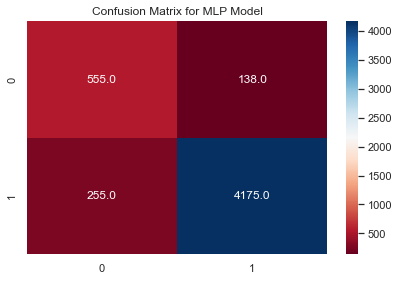

In [55]:
y_pred = mlp.predict(X_test)
acc = accuracy_score(y_pred, y_test)
report = classification_report(y_pred, y_test)
print(report)
cm = confusion_matrix(y_pred, y_test)
#np.set_printoptions(precision=0.01)
print("Accuracy of MLP Model: {}%".format(acc*100))
sns.heatmap(cm, annot=True, fmt = ".1f",cmap="RdBu")
plt.title("Confusion Matrix for MLP Model")

Text(0.5, 1.0, 'ROC curve for MLP Classifier')

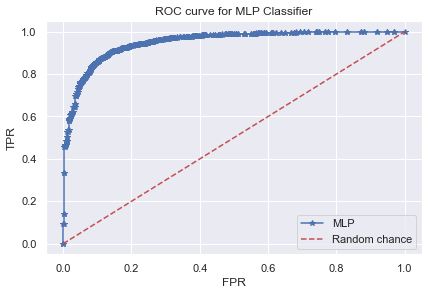

In [56]:
y_pred_proba = mlp.predict_proba(X_test)
pos_proba = y_pred_proba[:,1]
fpr, tpr, thersholds = roc_curve(y_test, pos_proba)
plt.plot(fpr, tpr, "*-")
plt.plot([0,1],[0,1],'r--')
plt.legend(['MLP', 'Random chance'])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve for MLP Classifier')

### Random Forest 

In [57]:
from sklearn.ensemble import RandomForestClassifier

In [58]:
# train a random forest classifier
rf = RandomForestClassifier(n_estimators = 100, random_state = 24)
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=24)

In [59]:
rf.score(X_test, y_test)

0.8942026156548897

              precision    recall  f1-score   support

           0       0.69      0.80      0.74       693
           1       0.97      0.94      0.96      4430

    accuracy                           0.92      5123
   macro avg       0.83      0.87      0.85      5123
weighted avg       0.93      0.92      0.93      5123

Accuracy of RF Model: 92.32871364434901%


Text(0.5, 1.0, 'Confusion Matrix for RF Model')

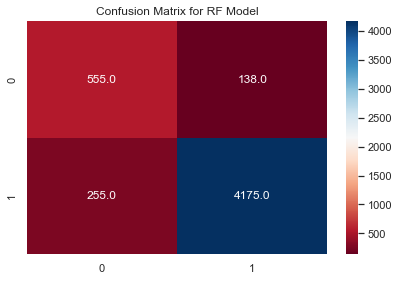

In [60]:
y_pred = mlp.predict(X_test)
acc = accuracy_score(y_pred, y_test)
report = classification_report(y_pred, y_test)
print(report)
cm = confusion_matrix(y_pred, y_test)
#np.set_printoptions(precision=0.01)
print("Accuracy of RF Model: {}%".format(acc*100))
sns.heatmap(cm, annot=True, fmt = ".1f",cmap="RdBu")
plt.title("Confusion Matrix for RF Model")

Text(0.5, 1.0, 'ROC curve for RF Classifier')

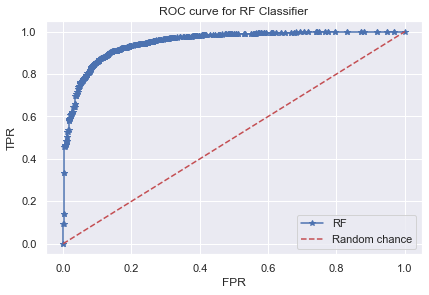

In [61]:
y_pred_proba = mlp.predict_proba(X_test)
pos_proba = y_pred_proba[:,1]
fpr, tpr, thersholds = roc_curve(y_test, pos_proba)
plt.plot(fpr, tpr, "*-")
plt.plot([0,1],[0,1],'r--')
plt.legend(['RF', 'Random chance'])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve for RF Classifier')

<div class="alert alert-box alert-warning">
Out of all the Models we used, LGBM model performes best with Accuracy of 92.5%.

So, we are considering LGBM Classifier Model.
</div>

# Prediction and Accuracy

In [62]:
y_pred = lgb.predict(X_test)

              precision    recall  f1-score   support

           0       0.64      0.84      0.72       617
           1       0.98      0.93      0.96      4506

    accuracy                           0.92      5123
   macro avg       0.81      0.89      0.84      5123
weighted avg       0.94      0.92      0.93      5123

Accuracy of LGBM Model: 92.32871364434901%


Text(0.5, 1.0, 'Confusion Matrix for LGBM Model')

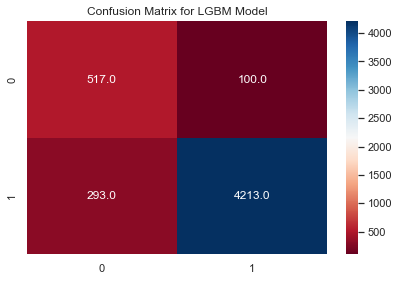

In [63]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
acc = accuracy_score(y_pred, y_test)
report = classification_report(y_pred, y_test)
print(report)
cm = confusion_matrix(y_pred, y_test)
#np.set_printoptions(precision=0.01)
print("Accuracy of LGBM Model: {}%".format(acc*100))
sns.heatmap(cm, annot=True, fmt = ".1f",cmap="RdBu")
plt.title("Confusion Matrix for LGBM Model")

## ROC_AUC Score and Curve
* The receiver operating characteristic (ROC) curve is a plot of the pairs of true positive rates (y-axis) and false positive rates (x-axis) that result from lowering the threshold down from 1, all the way to 0.

In [64]:
from sklearn.metrics import roc_auc_score, roc_curve
y_pred_proba = lgb.predict_proba(X_test)
pos_proba = y_pred_proba[:,1]

Text(0.5, 1.0, 'ROC curve for LGB Classifier')

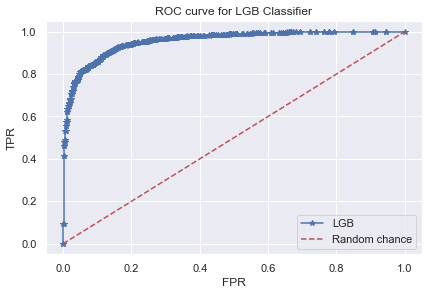

In [65]:
fpr, tpr, thersholds = roc_curve(y_test, pos_proba)
plt.plot(fpr, tpr, "*-")
plt.plot([0,1],[0,1],'r--')
plt.legend(['LGB', 'Random chance'])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve for LGB Classifier')

In [66]:
roc_auc_score(y_test, pos_proba)

0.9561154476990322

* Values closer to 1 in roc_auc_score shows that classifier is efficient and gives better performance.